This notebook compares the accuracy of multiple data driven ROM methods on the 3 segment system

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da



import opinf


config = dotenv_values(".env")
from util import *

In [2]:
# Set up hyperparameters for all ROMs
n_ROM = 12 # Dimensionality of state in ROM
n_timesteps = 200 # Number of timesteps to pull from each episode
n_train = 5 # Number of training episodes
n_test = 25 # Number of testing episodes

# Read Data

In [3]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/threeSegmentData200Timesteps/"
# Read in a single data file to get dimensions
# data = np.load(filepath + "processedData_policySeed_0.npz")
# n = data["stateData"].shape[1] # number of states
# l = data["inputData"].shape[1] # number of inputs
# m = data["reducedCenterlineData"].shape[1] # number of centerline points
# # initialize 3D matrices to hold data from all episodes
# X_fom = np.zeros((n,n_timesteps,n_train+n_test))
# U_fom = np.zeros((l,n_timesteps,n_train+n_test))
# Y_fom = np.zeros((m,n_timesteps,n_train+n_test))
# Xdot_fom = np.zeros((n,n_timesteps,n_train+n_test))



In [4]:
# Read in all data 
data = np.load(filepath+ "processedDataSet.npz")
print("gothere")
X_fom = da.from_array(data["stateData"], chunks=(data["stateData"].shape[0],data["stateData"].shape[1],1))
U_fom = da.from_array(data["inputData"], chunks=(data["inputData"].shape[0],data["inputData"].shape[1],1))
Y_fom = da.from_array(data["reducedCenterlineData"], chunks=(data["reducedCenterlineData"].shape[0],data["reducedCenterlineData"].shape[1],1))
print("gothere2")
n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]
print("gothere3")
# del data # free up memory
# Collect initial condition offsets for each episode and center each episode
X0 = da.zeros((n,n_train+n_test))
Y0 = da.zeros((m,n_train+n_test))
for i in range(n_train+n_test):
    X0[:,i] = X_fom[:,0,i]
    Y0[:,i] = Y_fom[:,0,i]
    X_fom[:,:,i] = X_fom[:,:,i] - X0[:,i].reshape(-1,1)
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y0[:,i].reshape(-1,1)
print("Done")
    

gothere
gothere2
gothere3
Done


KeysView(<numpy.lib.npyio.NpzFile object at 0x7f8a61389f40>)

In [9]:
# Get length of robot from min and max of x coords
xzCoords = Y0[:,0].reshape(-1,2)

x_min = np.min(xzCoords[:,1])
x_max = np.max(xzCoords[:,1])
length = x_max - x_min
print("Length of robot: ", length.compute())
# Get z min and max
z_min = np.min(xzCoords[:,1])
z_max = np.max(xzCoords[:,1])


Length of robot:  620.4809327651437


In [5]:
# Print shapes of data
print("Shape of X_fom: ", X_fom.shape)
print("Shape of U_fom: ", U_fom.shape)
print("Shape of Y_fom: ", Y_fom.shape)

Shape of X_fom:  (226941, 200, 30)
Shape of U_fom:  (6, 200, 30)
Shape of Y_fom:  (40, 200, 30)


# Learn System Matrices for Each Method

## SVD to find correct size of bases

In [11]:
# Compute SVD of state training set to find size of reduced basis
# Unroll the state training set into a matrix
X_fom_train_da = da.hstack([X_fom[:,:,i] for i in range(n_train)])
# Get shape of state training set
print(X_fom_train_da.shape)
# compute singular values of unrolled state training set
U_fom_train_da, S_fom_train_da, V_fom_train_da = da.linalg.svd_compressed(X_fom_train_da, 200)  
# Compute normalized singular values
S_fom_train_norm = S_fom_train_da / da.sum(S_fom_train_da)
S_fom_train_norm = S_fom_train_norm.compute()


(226941, 1000)


[0.41640648 0.60253485 0.68691626 0.75384118 0.81044994 0.84445603
 0.87078784 0.89371347 0.90911094 0.92266729 0.93224268 0.9394187
 0.94561004 0.94999628 0.95380618 0.95733721 0.96033804 0.96311884
 0.96557208 0.96789802 0.97004712 0.97211049 0.97375671 0.97523971
 0.97668893 0.97806937 0.97939996 0.98066094 0.98169152 0.98269963
 0.98364269 0.98451422 0.98532266 0.98608501 0.98677955 0.9874309
 0.98805672 0.98864713 0.98919392 0.98971101 0.99020044 0.99067291
 0.99110964 0.99151931 0.99190419 0.99228215 0.99261828 0.99293911
 0.99324892 0.99353155 0.99379665 0.9940477  0.99428433 0.9945198
 0.99474325 0.99495869 0.99516638 0.9953581  0.99554465 0.99572349
 0.99588733 0.99603527 0.99617214 0.99630684 0.99643731 0.99656209
 0.99668483 0.99679535 0.9969007  0.99700168 0.9971013  0.99720049
 0.99729407 0.99738079 0.99746255 0.99754059 0.99761681 0.99768891
 0.99776    0.9978307  0.99789966 0.99796383 0.99802656 0.99808757
 0.99814563 0.99820053 0.99825364 0.99830467 0.99835516 0.9984044

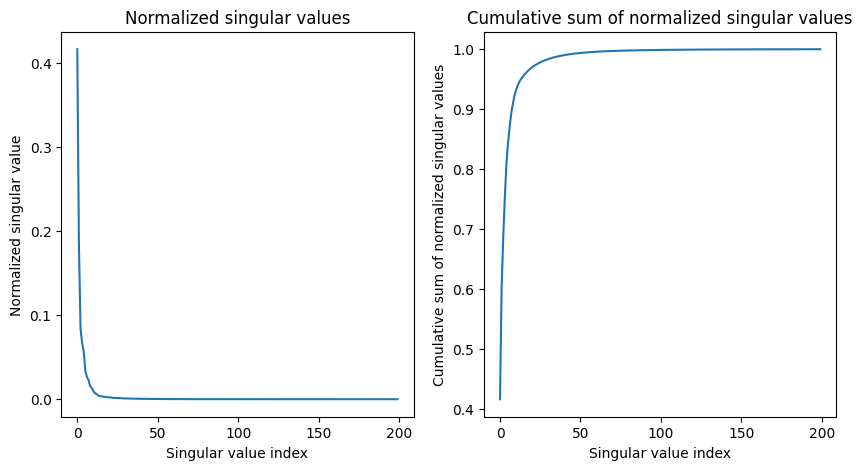

: 

In [12]:
# Plot normalized singular values and the cumulative sum of normalized singular values
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(S_fom_train_norm)
plt.title('Normalized singular values')
plt.xlabel('Singular value index')
plt.ylabel('Normalized singular value')
plt.subplot(1,2,2)
plt.plot(np.cumsum(S_fom_train_norm))
plt.title('Cumulative sum of normalized singular values')
plt.xlabel('Singular value index')
plt.ylabel('Cumulative sum of normalized singular values')

# print(np.cumsum(S_fom_train_norm))


## OKID + ERA 

### Setup Data matrices  

In [ ]:
# Grab input-output data from single episode 
U_era = U_fom[:,:,0]
Y_era = Y_fom[:,:,0]
# # Center output data around initial conditions
# Y_offset_era = Y_era[:,0].reshape(-1,1)
# Y_era = Y_era - Y_offset_era



### OKID Algorithm 

In [ ]:
YY = Y_era
UU_size = (U_era.shape[0]*U_era.shape[1],U_era.shape[1])
UU = np.zeros(UU_size)

for i in range(U_era.shape[1]):
    startRow = i*U_era.shape[0]
    endRow = (i+1)*U_era.shape[0]
    UU[startRow:endRow,i:] = U_era[:,0:(U_era.shape[1]-i)]

# compute pseudoinverse of input matrix
UU_pinv = np.linalg.pinv(UU)
# Solve for impulse response  
IR = np.matmul(YY,UU_pinv)


### Eigensystem Realization Algorithm

In [ ]:
# Form Hankel matrix for ERA 
N = int(n_timesteps/2-1)
H_size = (m*N,l*N)

H = np.zeros(H_size)
Hprime = np.zeros(H_size)

for i in range(N):
    startRow = m*i 
    endRow = m*(i+1)
    H[startRow:endRow,:]=IR[:,l*(1+i):l*(1+i+N)]
    Hprime[startRow:endRow,:]=IR[:,l*(2+i):l*(2+i+N)]


In [ ]:
# Get SVD of Hankel matrix
U, S, Vh = np.linalg.svd(H, full_matrices=False)

In [ ]:
# Plot singular values to determine truncation point
plt.figure()
plt.semilogy(S)
plt.title("Singular Values of Hankel Matrix")
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")

In [ ]:
# Truncate SVD
U = U[:,:n_ROM]
S = np.diag(S[:n_ROM])
Vh = Vh[:n_ROM,:]

In [ ]:
# Solve for system matrices
Sigma_tilde_is = np.linalg.inv(np.sqrt(S)) # inverse squareroot of sigma matrix
Sigma_tilde_sqrt = np.sqrt(S) # squareroot of sigma matrix


Em = np.concatenate([np.eye(l),np.zeros((l*(N-1),l))],axis=0)
Ep = np.concatenate([np.eye(m),np.zeros((m*(N-1),m))],axis=0)

A_era = np.matmul(np.matmul(np.matmul(np.matmul(Sigma_tilde_is,np.transpose(U)),Hprime),np.transpose(Vh)),Sigma_tilde_is)
B_era = np.matmul(np.matmul(Sigma_tilde_sqrt,Vh),Em)
C_era = np.matmul(np.transpose(Ep),np.matmul(U,Sigma_tilde_sqrt))
D_era = IR[:,:l]


In [ ]:
# clean up memory except for system matrices
del U_era, Y_era, YY, UU, UU_pinv, IR, H, Hprime, U, S, Vh, Sigma_tilde_is, Sigma_tilde_sqrt, Em, Ep


## DMDc

### Setup Data Matrices

In [ ]:
# Initialize data matrices for training and testing
X_train = np.zeros((n,(n_timesteps-1)*n_train))
Xprime_train = np.zeros((n,(n_timesteps-1)*n_train))
Upsilon_train = np.zeros((l,(n_timesteps-1)*n_train))
Y_train = np.zeros((m,(n_timesteps-1)*n_train))
# Load in data from training episodes
for i in range(n_train):
    X_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,:-1,i]
    Xprime_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,1:,i]
    Upsilon_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = U_fom[:,:-1,i]
    Y_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = Y_fom[:,:-1,i]


In [ ]:
# Form snapshot matrices for DMDc
Omega = np.concatenate([X_train,Upsilon_train],axis=0)


### Solve for Discrete Time System Matrices

In [ ]:
# Decompose snapshot matrix using truncated SVD
p_dmd = 1000
r_dmd = n_ROM

U_tilde,Sigma_tilde,Vh_tilde = randomized_svd(Omega, n_components=p_dmd)
Sigma_tilde = np.diag(Sigma_tilde)
U_hat, Sigma_hat, V_hat = randomized_svd(Xprime_train, n_components=r_dmd)
Sigma_hat = np.diag(Sigma_hat)



In [ ]:
# Compute system state evolution matrices
U_tilde_1 = U_tilde[0:n,:]
U_tilde_2 = U_tilde[n:,:]
A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(np.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(np.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

In [ ]:
# Solve for system output matrix from full order system
ys = Y_train[:,0:10]
X_PI = np.linalg.pinv(X_train[:,0:10])
C_dmdc = ys@X_PI

In [ ]:
# Clean up memory except for system matrices
del  Xprime_train, Upsilon_train, Omega, U_tilde, Sigma_tilde, Vh_tilde, Sigma_hat, V_hat, U_tilde_1, U_tilde_2, X_PI, ys

## OpInf

### Setup Data Matrices

In [ ]:
# Simulation Parameters
dt = 0.001
t = np.arange(0,dt*n_timesteps,dt)


In [ ]:
# Initialize data matrices for training and testing
Q_train = np.zeros((n,(n_timesteps)*n_train))
Qdot_train = np.zeros((n,(n_timesteps)*n_train))
Upsilon_train = np.zeros((l,(n_timesteps)*n_train))
Y_train = np.zeros((m,(n_timesteps)*n_train))
# Load in data from training episodes
for i in range(n_train):
    Q_train[:,i*(n_timesteps):(i+1)*(n_timesteps)] = X_fom[:,:,i]
    Qdot_train[:,i*(n_timesteps):(i+1)*(n_timesteps)] = opinf.pre.ddt(X_fom[:,:,i], dt, order=6) 
    Upsilon_train[:,i*(n_timesteps):(i+1)*(n_timesteps)] = U_fom[:,:,i]
    Y_train[:,i*(n_timesteps):(i+1)*(n_timesteps)] = Y_fom[:,:,i]


In [ ]:
# Setup OpInf Solver
t = np.arange(0,dt*n_timesteps,dt)
basis = opinf.pre.PODBasis().fit(Q_train,r=n_ROM) # fit basis to training data
rom_opInf = opinf.DiscreteOpInfROM(modelform="AB") 
solver = opinf.lstsq.L2Solver(regularizer=1e-2)         # Select a least-squares solver with regularization.
rom_opInf.fit(basis, Q_train, Qdot_train, Upsilon_train,solver=solver)                  # Construct the ROM by solving the operator inference.


In [ ]:
# Extract system matrices from OpInf ROM
A_opInf = np.array(rom_opInf.A_.entries)
B_opInf = np.array(rom_opInf.B_.entries)
basis_opInf = np.array(basis.entries)


In [ ]:
# Solve for system output matrix from full order system
ys = Y_train[:,0:10]
X_PI = np.linalg.pinv(X_train[:,0:10])
C_opInf = ys@X_PI

In [ ]:
# Clean up memory except for system matrices
del Q_train, Qdot_train, Upsilon_train, Y_train, t, basis, rom_opInf, solver, X_PI, ys

## LOpInf

In [ ]:
# Read in continuous time operators from file
mat = scipy.io.loadmat(filepath+'lopinf_rom_r_6_operators.mat')
Bhat_lopinf = mat['Bhat']
Chat_lopinf = mat['Chat']
Ehat_lopinf = mat['Ehat']
Khat_lopinf = mat['Khat']
Mhat_lopinf = mat['Mhat']
# Form continuous time linear state space matrices
A_lopinf_ct = np.block([
    [np.zeros((n_ROM//2,n_ROM//2)),np.eye(n_ROM//2)],
    [-Khat_lopinf, -Chat_lopinf]
])
B_lopinf_ct = np.block([
    [np.zeros((n_ROM//2,l))],
    [Bhat_lopinf]
])
C_lopinf_ct = np.block([
    [Ehat_lopinf, np.zeros((m,n_ROM//2))]
])
D_lopinf_ct = np.zeros((m,l))
# Convert continuous time operators to discrete time operators
A_lopinf_dt = scipy.linalg.expm(A_lopinf_ct*dt)
B_lopinf_dt = (A_lopinf_dt-np.eye(n_ROM))@np.linalg.inv(A_lopinf_ct)@B_lopinf_ct
C_lopinf_dt = C_lopinf_ct
D_lopinf_dt = D_lopinf_ct

A_lopinf, B_lopinf, C_lopinf, D_lopinf, dt_lopinf = cont2discrete((A_lopinf_ct, B_lopinf_ct, C_lopinf_ct,D_lopinf_ct), dt, method='zoh')

In [ ]:
# Print sizes of A matrices
# print('A_dmdc: ', A_dmdc.shape)
# print('A_opInf: ', A_opInf.shape)
# print('A_lopinf: ', A_lopinf.shape)
# Check if lopinf matrices are identical betweeen continuous and discrete time 
print(np.equal(C_lopinf_dt,C_lopinf).all())
print(np.equal(D_lopinf_dt,D_lopinf).all())
print(np.equal(A_lopinf_dt,A_lopinf).all())
print(np.equal(B_lopinf_dt,B_lopinf).all())



# Save System Matrices for Control Experiments


In [ ]:
# Save system matrices, projection mappings, and initial offset into file for later use
np.savez(filepath+f"romSystemMatrices_{n_ROM}dim_{n_train}train_{n_test}test.npz", A_era=A_era, B_era=B_era, C_era=C_era, D_era=D_era, A_dmdc=A_dmdc, B_dmdc=B_dmdc, C_dmdc=C_dmdc@U_hat, basis_dmdc = U_hat, A_opInf=A_opInf, B_opInf=B_opInf, C_opInf=C_opInf@basis_opInf ,basis_opInf=basis_opInf,A_lopinf=A_lopinf_dt,B_lopinf=B_lopinf_dt,C_lopinf=C_lopinf_dt,D_lopinf = D_lopinf_dt, x0=X0[:,0])
# save as .mat file
scipy.io.savemat(filepath+f"romSystemMatrices_{n_ROM}dim_{n_train}train_{n_test}test.mat", mdict={'A_era': A_era, 'B_era': B_era, 'C_era': C_era, 'D_era': D_era, 'A_dmdc': A_dmdc, 'B_dmdc': B_dmdc, 'C_dmdc': C_dmdc@U_hat, 'basis_dmdc': U_hat, 'A_opInf': A_opInf, 'B_opInf': B_opInf, 'C_opInf': C_opInf@basis_opInf, 'basis_opInf': basis_opInf, 'A_lopinf': A_lopinf_dt, 'B_lopinf': B_lopinf_dt, 'C_lopinf': C_lopinf_dt, 'D_lopinf': D_lopinf_dt, 'x0': X0[:,0]})

# Verification Experiments

## Simulate System Responses from Training and Test Episodes

### OKID/ERA

In [ ]:
# Initialize data matrices for training and testing responses
X_hat_rom_era = np.zeros((n_ROM,n_timesteps,n_train+n_test))
Y_hat_rom_era = np.zeros((m,n_timesteps,n_train+n_test))
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_era[:,[0],i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_era[:,[0],i] = C_era@X_hat_rom_era[:,[0],i] + D_era@U_fom[:,[0],i]


In [ ]:
# Simulate ERA ROM for all episodes
for i in range(n_train+n_test):
    # Simulate ERA ROM
    for j in range(n_timesteps-1):
        X_hat_rom_era[:,[j+1],i] = A_era@X_hat_rom_era[:,[j],i] + B_era@U_fom[:,[j],i]
        Y_hat_rom_era[:,[j+1],i] = C_era@X_hat_rom_era[:,[j+1],i] + D_era@U_fom[:,[j+1],i]


In [ ]:
# Uncenter output data with initial conditions for each episode
for i in range(n_train+n_test):
    Y_hat_rom_era[:,:,i] = Y_hat_rom_era[:,:,i] + Y0[:,i].reshape(m,1)


In [ ]:
# Clear some memory
del X_hat_rom_era

### DMDc

In [ ]:
# Initialize data matrices for training and testing responses
X_hat_rom_dmdc = np.zeros((n_ROM,n_timesteps,n_train+n_test))
X_hat_fom_dmdc = np.zeros((n,n_timesteps,n_train+n_test))
Y_hat_rom_dmdc = np.zeros((m,n_timesteps,n_train+n_test))
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_dmdc[:,[0],i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    X_hat_fom_dmdc[:,[0],i] = X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_dmdc[:,[0],i] = C_dmdc@U_hat@X_hat_rom_dmdc[:,[0],i]

In [ ]:
# Simulate DMDc ROM for all episodes
for i in range(n_train+n_test):
    # Simulate DMDc ROM
    for j in range(n_timesteps-1):
        X_hat_rom_dmdc[:,[j+1],i] = A_dmdc@X_hat_rom_dmdc[:,[j],i] + B_dmdc@U_fom[:,[j],i]
        X_hat_fom_dmdc[:,[j+1],i] = U_hat@X_hat_rom_dmdc[:,[j+1],i] # Compute full order state from reduced order state
        Y_hat_rom_dmdc[:,[j+1],i] = C_dmdc@U_hat@X_hat_rom_dmdc[:,[j+1],i]

In [ ]:
# Uncenter FOM state and output data with initial conditions for each episode
for i in range(n_train+n_test):
    X_hat_fom_dmdc[:,:,i] = X_hat_fom_dmdc[:,:,i] + X0[:,i].reshape(n,1)
    Y_hat_rom_dmdc[:,:,i] = Y_hat_rom_dmdc[:,:,i] + Y0[:,i].reshape(m,1)

In [ ]:
# Clear some memory
del X_hat_rom_dmdc, X_hat_fom_dmdc

### OpInf

In [ ]:
# Initialize data matrices for training and testing responses
X_hat_rom_opInf = np.zeros((n_ROM,n_timesteps,n_train+n_test))
X_hat_fom_opInf = np.zeros((n,n_timesteps,n_train+n_test))
Y_hat_rom_opInf = np.zeros((m,n_timesteps,n_train+n_test))
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_opInf[:,[0], i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    X_hat_fom_opInf[:,[0], i] = X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_opInf[:,[0], i] = C_opInf@X_hat_fom_opInf[:,[0],i]
    

In [ ]:
# Simulate OpInf ROM for all episodes
for i in range(n_train+n_test):
    # Simulate OpInf ROM
    for j in range(n_timesteps-1):
        X_hat_rom_opInf[:,[j+1], i] = A_opInf@X_hat_rom_opInf[:,[j], i] + B_opInf@U_fom[:,[j], i]
        X_hat_fom_opInf[:,[j+1], i] = basis_opInf@X_hat_rom_opInf[:,[j+1],i] # Compute full order state from reduced order state
        Y_hat_rom_opInf[:,[j+1], i] = C_opInf@X_hat_fom_opInf[:,[j+1],i]

In [ ]:
# Clear some memory
del X_hat_rom_opInf, X_hat_fom_opInf

In [ ]:
# Uncenter FOM state and output data with initial conditions for each episode
for i in range(n_train+n_test):
    # X_hat_fom_opInf[:,:,i] = X_hat_fom_opInf[:,:,i] + X0[:,i].reshape(n,1)
    Y_hat_rom_opInf[:,:,i] = Y_hat_rom_opInf[:,:,i] + Y0[:,i].reshape(m,1)

### LOpInf

In [ ]:
# Read in data from LOpInf Trials

mat = mat73.loadmat(filepath+'lopinf_rom_r_6.mat')
# X_hat_rom_lopinf = mat['stateData_approx']
Y_hat_rom_lopinf = mat['outputData_approx']


In [ ]:
del mat

In [ ]:
# Also generate outputs from LOpInf discrete time model
# Initialize data matrices for training and testing responses
X_hat_rom_lopinf_dt = np.zeros((n_ROM,n_timesteps,n_train+n_test))
X_hat_fom_lopinf_dt = np.zeros((n,n_timesteps,n_train+n_test))
Y_hat_rom_lopinf_dt = np.zeros((m,n_timesteps,n_train+n_test))
# Set initial conditions for each episode
for i in range(n_train+n_test):
    # Set initial states
    X_hat_rom_lopinf_dt[:,[0],i] = np.zeros((n_ROM,1)) #X_fom[:,[0],i]
    # X_hat_fom_lopinf_dt[:,[0],i] = X_fom[:,[0],i]
    # Compute initial outputs for each episode
    Y_hat_rom_lopinf_dt[:,[0],i] = C_lopinf_dt@X_hat_rom_lopinf_dt[:,[0],i]


In [ ]:
# Simulate LOpInf discrete time ROM for all episodes
for i in range(n_train+n_test):
    # Simulate LOpInf discrete time ROM
    for j in range(n_timesteps-1):
        X_hat_rom_lopinf_dt[:,[j+1],i] = A_lopinf_dt@X_hat_rom_lopinf_dt[:,[j],i] + B_lopinf_dt@U_fom[:,[j],i]
        Y_hat_rom_lopinf_dt[:,[j+1],i] = C_lopinf_dt@X_hat_rom_lopinf_dt[:,[j+1],i]

In [ ]:
# Uncenter FOM state and output data with initial conditions for each episode
for i in range(n_train+n_test):
    Y_hat_rom_lopinf_dt[:,:,i] = Y_hat_rom_lopinf_dt[:,:,i] + Y0[:,i].reshape(m,1)

### Uncenter Full Order Model

## Uncenter FOM


In [ ]:
# Uncenter FOM state and output data with initial conditions for each episode
for i in range(n_train+n_test):
    X_fom[:,:,i] = X_fom[:,:,i] + X0[:,i].reshape(n,1)
    Y_fom[:,:,i] = Y_fom[:,:,i] + Y0[:,i].reshape(m,1)
    

## Response Visualizations

In [ ]:
t = np.arange(0,dt*n_timesteps,dt)

### First Output Response

#### Training Set 1

In [ ]:
# Plot first output from first training episode for all modelling methods
plt.figure()
plt.plot(t,Y_fom[0,:,0],'k',label='FOM',linewidth=6)
plt.plot(t,Y_hat_rom_era[0,:,0],'r',label='ERA',linewidth=5)
plt.plot(t,Y_hat_rom_dmdc[0,:,0],'b',label='DMDc',linewidth=5)
#plt.plot(t,Y_hat_rom_opInf[0,:,0],'g',label='OpInf',linewidth=5)
plt.plot(t,Y_hat_rom_lopinf[0,:,0],'m',label='LOpInf',linewidth=5)
plt.plot(t,Y_hat_rom_lopinf_dt[0,:,0],'c',label='LOpInf DT',linewidth=5)
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('Output')
title = 'First Output from First Training Episode'
plt.title(title)

#### Test Set 1

In [ ]:
# Plot first output from first testing episode for all modelling methods
plt.figure()
plt.plot(t,Y_fom[0,:,n_train],'k',label='FOM',linewidth=5)
plt.plot(t,Y_hat_rom_era[0,:,n_train],'r',label='ERA',linewidth=5)
plt.plot(t,Y_hat_rom_dmdc[0,:,n_train],'b',label='DMDc',linewidth=5)
# plt.plot(t,Y_hat_rom_opInf[0,:,n_train],'g',label='OpInf',linewidth=5)
plt.plot(t,Y_hat_rom_lopinf[0,:,n_train],'m',label='LOpInf',linewidth=5)
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('Output')
title = 'First Output from First Testing Episode'
plt.title(title)


### First state Response

#### First Training Episode

In [ ]:
# Plot first state from first training episode for all modelling methods except ERA
plt.figure()
plt.plot(t,X_fom[0,:,0],'k',label='FOM',linewidth=5)
plt.plot(t,X_hat_fom_dmdc[0,:,0],'b',label='DMDc',linewidth=5)
# plt.plot(t,X_hat_fom_opInf[0,:,0],'g',label='OpInf',linewidth=5)
# plt.plot(t,X_hat_rom_lopinf[0,:,0],'m',label='LOpInf',linewidth=5)
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('State')
title = 'First State from First Training Episode'
plt.title(title)

#### First Test Episode

In [ ]:
# Plot first state from first testing episode for all modelling methods except ERA
plt.figure()
plt.plot(t,X_fom[0,:,n_train],'k',label='FOM',linewidth=5)
plt.plot(t,X_hat_fom_dmdc[0,:,n_train],'b',label='DMDc',linewidth=5)
#plt.plot(t,X_hat_fom_opInf[0,:,n_train],'g',label='OpInf',linewidth=5)
# plt.plot(t,X_hat_rom_lopinf[0,:,n_train],'m',label='LOpInf',linewidth=5)
legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
plt.xlabel('Time (s)')
plt.ylabel('State')
title = 'First State from First Testing Episode'
plt.title(title)

### Centerline Videos

In [ ]:
# Setup save path for videos
video_path = config["currentDirectory"] +"data/videos/"
videoName_test = 'test_episode_3segment.mp4'
videoName_train = 'train_episode_3segment.mp4'
# Number of frames and playspeed for video
numFrames = n_timesteps
fps = 30
duration = numFrames/fps
# Axis limits for video
xlim_max = 400
xlim_min =  -300
zlim_max = -165
zlim_min = -315
ulim_max = 0.2
ulim_min = -0.2
# # Parameters for centerline reduction 
# n_seg = 10 # number of discrete points to use for centerline
# N_local = 20 # number of local points to use when averaging around each discrete point



#### Training Set 1

Generate animation of centerline motion using output data from all modelling methods for the first training set


In [ ]:
# Set up figure
fig, ax = plt.subplots()
# Define animation callback
def animate(t):
    # Bring in global variables for output data of fom and each method
    global Y_fom, Y_hat_rom_era, Y_hat_rom_dmdc, Y_hat_rom_opInf, Y_hat_rom_lopinf
    # Get frame index
    i = int(round(t*fps))
    # Reshape centerline data for each method for the given timestep of the first training episode
    centerline_fom = Y_fom[:,i,0].reshape(-1,2)
    centerline_era = Y_hat_rom_era[:,i,0].reshape(-1,2)
    centerline_dmdc = Y_hat_rom_dmdc[:,i,0].reshape(-1,2)
    #centerline_opInf = Y_hat_rom_opInf[:,i,0].reshape(-1,2)
    centerline_lopinf = Y_hat_rom_lopinf[:,i,0].reshape(-1,2)
    # Compute reduced centerlines for each method
    centerline_fom_red = centerline_fom
    centerline_era_red = centerline_era
    centerline_dmdc_red = centerline_dmdc
    centerline_lopinf_red = centerline_lopinf
    #centerline_opInf_red = reduceCenterline(n_seg,centerline_opInf,N_local)
    # centerline_lopinf_red = reduceCenterline(n_seg,centerline_lopinf,N_local)
    # Plot reduced centerlines
    ax.clear()
    ax.plot(centerline_fom_red[:,1],centerline_fom_red[:,0],'k',label='FOM',linewidth=5)
    ax.plot(centerline_era_red[:,1],centerline_era_red[:,0],'r',label='ERA',linewidth=5)
    ax.plot(centerline_dmdc_red[:,1],centerline_dmdc_red[:,0],'b',label='DMDc',linewidth=5)
    #ax.plot(centerline_opInf_red[:,0],centerline_opInf_red[:,1],'g',label='OpInf',linewidth=5)
    ax.plot(centerline_lopinf_red[:,1],centerline_lopinf_red[:,0],'m',label='LOpInf',linewidth=5)
    ax.set_xlim(xlim_min,xlim_max)
    ax.set_ylim(zlim_min,zlim_max)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('z (mm)')
    ax.set_title('Centerline at timestep '+str(i))
    legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
    return mplfig_to_npimage(fig)

animation = VideoClip(animate, duration=duration)
animation.write_videofile(video_path+videoName_train, fps=fps)



#### Test Set 1

In [ ]:
# Set up figure
fig, ax = plt.subplots()
# Define animation callback 
def animate(t):
    # Bring in global variables for output data of fom and each method
    global Y_fom, Y_hat_rom_era, Y_hat_rom_dmdc, Y_hat_rom_opInf, Y_hat_rom_lopinf
    # Get frame index
    i = int(round(t*fps))
    # Reshape centerline data for each method for the given timestep of the first testing episode
    centerline_fom = Y_fom[:,i,n_train].reshape(-1,2)
    centerline_era = Y_hat_rom_era[:,i,n_train].reshape(-1,2)
    centerline_dmdc = Y_hat_rom_dmdc[:,i,n_train].reshape(-1,2)
    #centerline_opInf = Y_hat_rom_opInf[:,i,0].reshape(-1,2)
    centerline_lopinf = Y_hat_rom_lopinf[:,i,n_train].reshape(-1,2)
    # Compute reduced centerlines for each method
    centerline_fom_red = centerline_fom
    centerline_era_red = centerline_era
    centerline_dmdc_red = centerline_dmdc
    centerline_lopinf_red = centerline_lopinf
    #centerline_opInf_red = reduceCenterline(n_seg,centerline_opInf,N_local)
    # centerline_lopinf_red = reduceCenterline(n_seg,centerline_lopinf,N_local)
    # Plot reduced centerlines
    ax.clear()
    ax.plot(centerline_fom_red[:,1],centerline_fom_red[:,0],'k',label='FOM',linewidth=5)
    ax.plot(centerline_era_red[:,1],centerline_era_red[:,0],'r',label='ERA',linewidth=5)
    ax.plot(centerline_dmdc_red[:,1],centerline_dmdc_red[:,0],'b',label='DMDc',linewidth=5)
    #ax.plot(centerline_opInf_red[:,0],centerline_opInf_red[:,1],'g',label='OpInf',linewidth=5)
    ax.plot(centerline_lopinf_red[:,1],centerline_lopinf_red[:,0],'m',label='LOpInf',linewidth=5)
    ax.set_xlim(xlim_min,xlim_max)
    ax.set_ylim(zlim_min,zlim_max)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('z (mm)')
    ax.set_title('Centerline at timestep '+str(i))
    legend = plt.legend(loc='upper right', shadow=False, fontsize='medium')
    return mplfig_to_npimage(fig)

animation = VideoClip(animate, duration=duration)
animation.write_videofile(video_path+videoName_test, fps=fps)



## Relative Error Computations

### Relative Output Errors

#### Training Episodes

In [ ]:
# Compute relative error in frobenius norm for all training episodes
rel_err_era_train = np.zeros((n_train,1))
rel_err_dmdc_train = np.zeros((n_train,1))
rel_err_opInf_train = np.zeros((n_train,1))
rel_err_lopinf_train = np.zeros((n_train,1))
for i in range(n_train):
    rel_err_era_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_era[:,:,i])/np.linalg.norm(Y_fom[:,:,i])
    rel_err_dmdc_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_dmdc[:,:,i])/np.linalg.norm(Y_fom[:,:,i])
    rel_err_opInf_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_opInf[:,:,i])/np.linalg.norm(Y_fom[:,:,i])
    rel_err_lopinf_train[i] = np.linalg.norm(Y_fom[:,:,i]-Y_hat_rom_lopinf[:,:,i])/np.linalg.norm(Y_fom[:,:,i])

#### Test Episodes


In [ ]:
# Compute relative error in frobenius norm for all testing episodes
rel_err_era_test = np.zeros((n_test,1))
rel_err_dmdc_test = np.zeros((n_test,1))
rel_err_opInf_test = np.zeros((n_test,1))
rel_err_lopinf_test = np.zeros((n_test,1))
for i in range(n_test):
    rel_err_era_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_era[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])
    rel_err_dmdc_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_dmdc[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])
    rel_err_opInf_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_opInf[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])
    rel_err_lopinf_test[i] = np.linalg.norm(Y_fom[:,:,i+n_train]-Y_hat_rom_lopinf[:,:,i+n_train])/np.linalg.norm(Y_fom[:,:,i+n_train])

In [ ]:
# Make bar plot with error bars for training and testing episodes for each method
fig, ax = plt.subplots()
ax.bar(np.arange(0,8,2)-0.45,[np.mean(rel_err_era_train),np.mean(rel_err_dmdc_train),np.mean(rel_err_opInf_train),np.mean(rel_err_lopinf_train)],yerr=[np.std(rel_err_era_train),np.std(rel_err_dmdc_train),np.std(rel_err_opInf_train),np.std(rel_err_lopinf_train)],color=['r','b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,8,2)+0.45,[np.mean(rel_err_era_test),np.mean(rel_err_dmdc_test),np.mean(rel_err_opInf_test),np.mean(rel_err_lopinf_test)],yerr=[np.std(rel_err_era_test),np.std(rel_err_dmdc_test),np.std(rel_err_opInf_test),np.std(rel_err_lopinf_test)],color=['r','b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
ax.set_ylabel('Relative error')
ax.set_xticks(np.arange(0,8,2))
ax.set_xticklabels(['ERA','DMDc','OpInf','LOpInf'])
ax.set_title('Relative output error for training and testing episodes')
ax.yaxis.grid(True)
ax.legend(['Training','Testing'])
# plt.tight_layout()


### Relative State Errors

In [ ]:
# Compute relative error in frobenius norm for all training episodes of full order states for each method except ERA
rel_err_dmdc_train_full = np.zeros((n_train,1))
rel_err_opInf_train_full = np.zeros((n_train,1))
rel_err_lopinf_train_full = np.zeros((n_train,1))
for i in range(n_train):
    rel_err_dmdc_train_full[i] = np.linalg.norm(X_fom[:,:,i]-X_hat_fom_dmdc[:,:,i])/np.linalg.norm(X_fom[:,:,i])
    rel_err_opInf_train_full[i] = np.linalg.norm(X_fom[:,:,i]-X_hat_fom_opInf[:,:,i])/np.linalg.norm(X_fom[:,:,i])
    # rel_err_lopinf_train_full[i] = np.linalg.norm(X_fom[:,:,i]-X_hat_rom_lopinf[:,:,i])/np.linalg.norm(X_fom[:,:,i])
    


In [ ]:
# Compute relative error in frobenius norm for all testing episodes of full order states for each method except ERA
rel_err_dmdc_test_full = np.zeros((n_test,1))
rel_err_opInf_test_full = np.zeros((n_test,1))
rel_err_lopinf_test_full = np.zeros((n_test,1))
for i in range(n_test):
    rel_err_dmdc_test_full[i] = np.linalg.norm(X_fom[:,:,i+n_train]-X_hat_fom_dmdc[:,:,i+n_train])/np.linalg.norm(X_fom[:,:,i+n_train])
    rel_err_opInf_test_full[i] = np.linalg.norm(X_fom[:,:,i+n_train]-X_hat_fom_opInf[:,:,i+n_train])/np.linalg.norm(X_fom[:,:,i+n_train])
    # rel_err_lopinf_test_full[i] = np.linalg.norm(X_fom[:,:,i+n_train]-X_hat_rom_lopinf[:,:,i+n_train])/np.linalg.norm(X_fom[:,:,i+n_train])



In [ ]:
# Make bar plot with error bars for training and testing episodes for each method
fig, ax = plt.subplots()
ax.bar(np.arange(0,6,2)-0.45,[np.mean(rel_err_dmdc_train_full),np.mean(rel_err_opInf_train_full),np.mean(rel_err_lopinf_train_full)],yerr=[np.std(rel_err_dmdc_train_full),np.std(rel_err_opInf_train_full),np.std(rel_err_lopinf_train_full)],color=['b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,6,2)+0.45,[np.mean(rel_err_dmdc_test_full),np.mean(rel_err_opInf_test_full),np.mean(rel_err_lopinf_test_full)],yerr=[np.std(rel_err_dmdc_test_full),np.std(rel_err_opInf_test_full),np.std(rel_err_lopinf_test_full)],color=['b','g','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
ax.set_ylabel('Relative error')
ax.set_xticks(np.arange(0,6,2))
ax.set_xticklabels(['DMDc','OpInf','LOpInf'])
ax.set_title('Relative full state error for training and testing episodes')
ax.yaxis.grid(True)
ax.legend(['Training','Testing'])
# plt.tight_layout()

